In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff, Optim
using SpecialFunctions
using BenchmarkTools
using  MAT, DSP, FFTW, WAV
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov

┌ Warning: Error requiring `Optimisers` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/PhD/ReactiveMP.jl/ext/ReactiveMPOptimisersExt/ReactiveMPOptimisersExt.jl", 1, ArgumentError("Package ReactiveMP does not have Optimisers in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Optimisers as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000016c0cc66f, Ptr{Nothing} @0x000000016c0cc83b, Ptr{Nothing} @0x000000010507d2a3, Ptr{Nothing} @0x00000001050b290b, Ptr{Nothing} @0x00000001050b1717, Ptr{Nothing} @0x00000001050b1a93, Ptr{Nothing} @0x00000001050b2073, Ptr{Nothing} @0x00000001050b2e07, Ptr{Nothing} @0x000000011ba67

┌ Warning: Error requiring `Zygote` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/PhD/ReactiveMP.jl/ext/ReactiveMPZygoteExt/ReactiveMPZygoteExt.jl", 1, ArgumentError("Package ReactiveMP does not have Zygote in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Zygote as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000016c0cc66f, Ptr{Nothing} @0x000000016c0cc83b, Ptr{Nothing} @0x000000010507d2a3, Ptr{Nothing} @0x00000001050b290b, Ptr{Nothing} @0x00000001050b1717, Ptr{Nothing} @0x00000001050b1a93, Ptr{Nothing} @0x00000001050b2073, Ptr{Nothing} @0x00000001050b2e07, Ptr{Nothing} @0x000000011ba67ed7, Ptr{Nothing} @0

## Prepare nodes and rules

In [3]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    if isnothing(messages[1].addons)
        @logscale 0.
    else
        @logscale logscale = getlogscale(messages[1])
    end
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    scalefactor = (x) -> exp(l_pdf(x))/exp(-x^2)
    x, w = ReactiveMP.gausshermite(9)
    Z = dot(w,scalefactor.(x))
    if isnothing(messages[1].addons)
        @logscale log(Z)
    else
        @logscale log(Z) + getlogscale(messages[1]) #correct 
    end

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v+1e-6)
    end
end

@marginalrule MyExponential(:x) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    b_x = @call_rule MyExponential(:x, Marginalisation) (m_y = m_y, m_x=m_x)
    q_x = ReactiveMP.prod(ProdAnalytical(),b_x,m_x)
    if isinf(entropy(m_x)) || isnan(entropy(m_x))
        q_x= m_x 
    end
    return (x=m_x)
end

In [4]:
@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)


    scalefactor = (x) -> exp(backward_A(x))/exp(-x^2)
    points, w = ReactiveMP.gausshermite(9)
    Z = dot(w,scalefactor.(points))
    if isnothing(messages[3].addons)
        @logscale log(Z)
    else
        @logscale log(Z) + getlogscale(messages[3])#correct 
    end

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v+1e-6)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    
    scalefactor = (x) -> exp(backward_A(x))/exp(-x^2)
    points, w = ReactiveMP.gausshermite(9)
    Z = dot(w,scalefactor.(points))
    if isnothing(messages[2].addons)
        @logscale log(Z)
    else
        @logscale log(Z) + getlogscale(messages[2])#correct 
    end
    return ContinuousUnivariateLogPdf(backward_A)
end

@marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::NormalMeanVariance, m_in::LogNormal, meta::TinyCorrection) = begin 
    b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
    q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)
    if isinf(entropy(q_A))
        q_A = m_A
    end
    return (A = q_A,in = m_in, out=m_out)
end

In [5]:
function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    return left
end

In [6]:
L = [0., 0., 1.];
H = [1., 0., 0.];
function compute_F(θ)
    λ = sqrt(5)/θ[1]
    return [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
end
function compute_P(θ)
    Qc = 16/3 * θ[2] * (sqrt(5)/θ[1])^5;
    F = compute_F(θ)
    Imat = diageye(3)
    P_vec = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L')
    return reshape(P_vec,3,3);
end
function compute_A(θ,Δt)
    F = compute_F(θ)
    A = [exp(F * i) for i in Δt];
    return A #vector of matrix A 
end

function compute_Q(θ,Δt)
    A = compute_A(θ,Δt)
    P = compute_P(θ)

    Q = [P - i*P*i' for i in A]
    return Q #vector of matrix Q 
end

compute_Q (generic function with 1 method)

In [7]:
@rule Categorical(:p, Marginalisation) (m_out::Categorical, q_out::PointMass) = begin
    @logscale -SpecialFunctions.logfactorial(length(probvec(q_out)))
    return Dirichlet(probvec(q_out) .+ one(eltype(probvec(q_out))))
end

struct EnforceMarginalFunctionalDependency <: ReactiveMP.AbstractNodeFunctionalDependenciesPipeline
    edge :: Symbol
end

function ReactiveMP.message_dependencies(::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    return ReactiveMP.message_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
end

function ReactiveMP.marginal_dependencies(enforce::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    default = ReactiveMP.marginal_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    index   = ReactiveMP.findnext(i -> name(i) === enforce.edge, nodeinterfaces, 1)
    if index === iindex 
        return default
    end
    vmarginal = ReactiveMP.getmarginal(ReactiveMP.connectedvar(nodeinterfaces[index]), IncludeAll())
    loc = ReactiveMP.FactorNodeLocalMarginal(-1, index, enforce.edge)
    ReactiveMP.setstream!(loc, vmarginal)
    # Find insertion position (probably might be implemented more efficiently)
    insertafter = sum(first(el) < iindex ? 1 : 0 for el in default; init = 0)
    return ReactiveMP.TupleTools.insertafter(default, insertafter, (loc, ))
end

# function for using hard switching
function ReactiveMP.functional_dependencies(::EnforceMarginalFunctionalDependency, factornode::MixtureNode{N, F}, iindex::Int) where {N, F <: FullFactorisation}
    message_dependencies = if iindex === 1
        # output depends on:
        (factornode.inputs,)
    elseif iindex === 2
        # switch depends on:
        (factornode.out, factornode.inputs)
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.out, )
    else
        error("Bad index in functional_dependencies for SwitchNode")
    end

    marginal_dependencies = if iindex === 1
        # output depends on:
        (factornode.switch,)
    elseif iindex == 2
        #  switch depends on
        ()
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.switch,)
    else
        error("Bad index in function_dependencies for SwitchNode")
    end
    # println(marginal_dependencies)
    return message_dependencies, marginal_dependencies
end

# create an observable that is used to compute the switch with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface, NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface  = messages[1]
    inputsinterfaces = messages[2]

    msgs_names = Val{(name(switchinterface), name(inputsinterfaces[1]))}()
    msgs_observable =
    combineLatest((ReactiveMP.messagein(switchinterface), combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew())), PushNew()) |>
        map_to((ReactiveMP.messagein(switchinterface), ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces))))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the output with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    inputsinterfaces = messages[1]

    msgs_names = Val{(name(inputsinterfaces[1]), )}()
    msgs_observable =
    combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew()) |>
        map_to((ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces)),))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the input with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    outputinterface = messages[1]

    msgs_names = Val{(name(outputinterface), )}()
    msgs_observable = combineLatestUpdates((ReactiveMP.messagein(outputinterface), ), PushNew())
    return msgs_names, msgs_observable
end

function ReactiveMP.get_marginals_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, marginals::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface = marginals[1]

    marginal_names       = Val{(name(switchinterface), )}()
    marginals_observable = combineLatestUpdates((getmarginal(ReactiveMP.connectedvar(switchinterface), IncludeAll()), ), PushNew())

    return marginal_names, marginals_observable
end


In [8]:
@constraints function constraints_MixturePAD()
    q(s) :: PointMass
end;

In [9]:
function ReactiveMP.prod(::ProdAnalytical, left::PointMass, right::UnivariateGaussianDistributionsFamily) 
    mean_left = mean(left)
    return pdf(right,mean_left)
end

## Test on real data

In [10]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [11]:
nsignal = 10
data = FilteredOutput[:,1:nsignal];
NumberOfSamples = length(data[:,1]);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
for i=1:nsignal
    data[:,i] = data[:,i] / sqrt(var(data[:,i]));
end
data = sum(data,dims=2)
# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

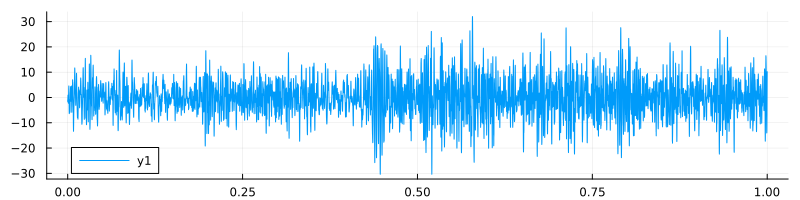

In [12]:
plot(t_data,y_data,size = (800,200))

In [ ]:
@model function Real_MixturePAD(n,nmixtures, nsubsamples, P_amp,A_amp,Q_amp,P_carr,A_carr,Q_carr,H)
    #we split the signal into batches, and nsubsamples is the number of samples in each batch 
    y = datavar(Float64,n)

    yk = randomvar(nmixtures,nsubsamples)
    fk_0 = randomvar(nmixtures)
    ck_0 = randomvar(nmixtures)
    fk = randomvar(nmixtures,nsubsamples)
    ck = randomvar(nmixtures,nsubsamples)

    zk = randomvar(nmixtures,nsubsamples)
    gk = randomvar(nmixtures,nsubsamples)
    dk = randomvar(nmixtures,nsubsamples)

    s = randomvar(n)


    for k=1:nmixtures
        fk_0[k] ~ MvNormalMeanCovariance(zeros(length(H)), P_amp[k])
        ck_0[k] ~ MvNormalMeanCovariance(zeros(length(H)), P_carr[k])
        f_prev = fk_0[k]
        c_prev = ck_0[k]
        for j=1:n
            fk[k,j] ~ MvNormalMeanCovariance(A_amp[k][j] * f_prev, Q_amp[k][j])
            zk[k,j] ~ NormalMeanVariance(dot(H , fk[k,j]), .1)
            gk[k,j] ~ MyExponential(zk[k,j]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., .5))}

            ck[k,j] ~ MvNormalMeanCovariance(A_carr[k][j] * c_prev, Q_carr[k][j])
            dk[k,j] ~ NormalMeanVariance(dot(H,ck[k,j]), .1) 

            yk[k,j] ~ (*)(dk[k,j],gk[k,j]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., .5))}
            f_prev = fk[k,j]
            c_prev = ck[k,j]
        end 
    end
    
    y_tup = tuple(yk...)
    π ~ Dirichlet(ones(nmixtures))

    for i=1:n 
        s[i] ~ Categorical(π) where { pipeline = EnforceMarginalFunctionalDependency(:out) }
        y[i] ~ Mixture(s[i], y_tup[(i-1)*nmixtures+1:i*nmixtures]) where { pipeline = EnforceMarginalFunctionalDependency(:switch) }
    end
end

In [ ]:
Δt = [t_data[2] - t_data[1]]; # time difference
append!(Δt, t_data[2:end] - t_data[1:end-1]);

L = [0., 0., 1.];
H = [1., 0., 0.];

In [ ]:
nmixtures = 3
θ_amplitude = [[0.015, 1.], [0.05, 0.5],[0.003,0.6]]
                #[0.0001, .5],[0.008, .5]]; #[l, σ²]

θ_carrier = [[0.00001, 1.], [0.0003, 0.5],[0.0000002,0.4]]
#[0.00000001, 1.],[0.0001, .5]]; # store [l, σ²]
;

In [ ]:
A_amplitude_tensor = [compute_A(i,Δt) for i in θ_amplitude]
Q_amplitude_tensor = [compute_Q(i,Δt) for i in θ_amplitude]
P_amplitude_tensor = [compute_P(i) for i in θ_amplitude]

A_carrier_tensor = [compute_A(i,Δt) for i in θ_carrier]
Q_carrier_tensor = [compute_Q(i,Δt) for i in θ_carrier]
P_carrier_tensor = [compute_P(i) for i in θ_carrier];

In [ ]:
nits =2

iresult = inference(
    model = Real_MixturePAD(length(y_data),nmixtures,P_amplitude_tensor,A_amplitude_tensor,Q_amplitude_tensor,P_carrier_tensor,A_carrier_tensor,Q_carrier_tensor,H),
    iterations = nits, 
    data  = (y = y_data,),
    initmessages = (π = Dirichlet(ones(nmixtures)),),
    initmarginals = (π = Dirichlet(ones(nmixtures)),),
    returnvars = (π = KeepLast(),fk = KeepLast(),),
    constraints = constraints_MixturePAD(),
    addons = AddonLogScale(),
    options = (limit_stack_depth=100,),
    showprogress = true
)